# Overview

# Params

# Import everything I need :)

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# my function

In [47]:
class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        if self.metric == 'auc':
            y_valid_score = self.model.predict_proba(X_valid)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
            self.base_score = auc(fpr, tpr)
        else:
            self.base_score = self.metric(y_valid, self.model.predict(X_valid))
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = self.model.predict(df_perm)
            if self.metric == 'auc':
                y_valid_score = self.model.predict_proba(df_perm)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
                score = auc(fpr, tpr)
            else:
                score = self.metric(y_valid, y_valid_pred)
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

# Experiment

create X,y

In [11]:
cancer = load_breast_cancer()
data = cancer.data
feat_names = cancer.feature_names
X = pd.DataFrame(data, columns=feat_names)
y = cancer.target

<br>

kfold

In [13]:
kf = KFold(n_splits=5, shuffle=True)
for fold_i, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.values[train_idx, :], X.values[valid_idx, :]
    y_train, y_valid = y[train_idx], y[valid_idx]

train test split

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

In [41]:
_model = DecisionTreeClassifier(random_state=42)
_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

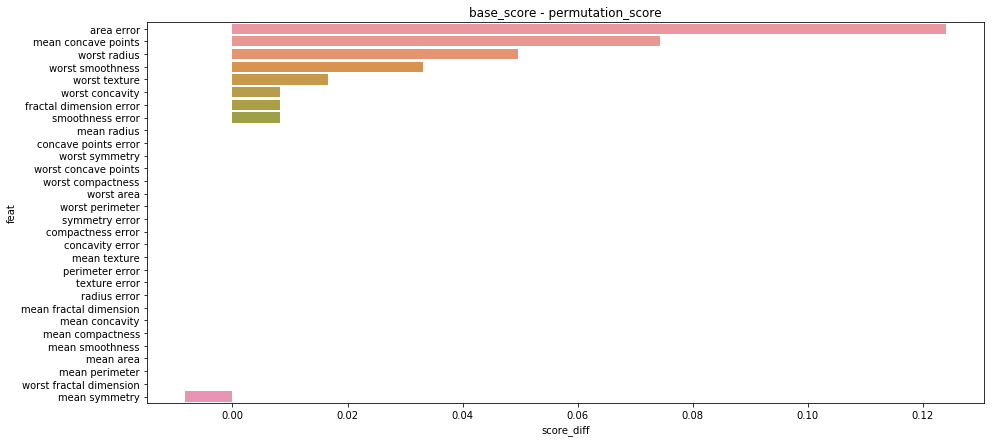

In [52]:
pi = permutation_importance(_model, recall_score) # model と metric を渡す
pi.compute(X_valid, y_valid)
pi.show_permutation_importance(score_type='accuracy')  # loss or accuracy

In [70]:
data = pi.df_result['score_diff'].values
feat = pi.df_result['feat']


In [80]:
df = pd.DataFrame(columns=feat)
# df = pd.DataFrame([data], columns=feat)
df

feat,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension


In [178]:
len(df_result.feat)

30

In [194]:
len(df_concat.feat.unique())

30

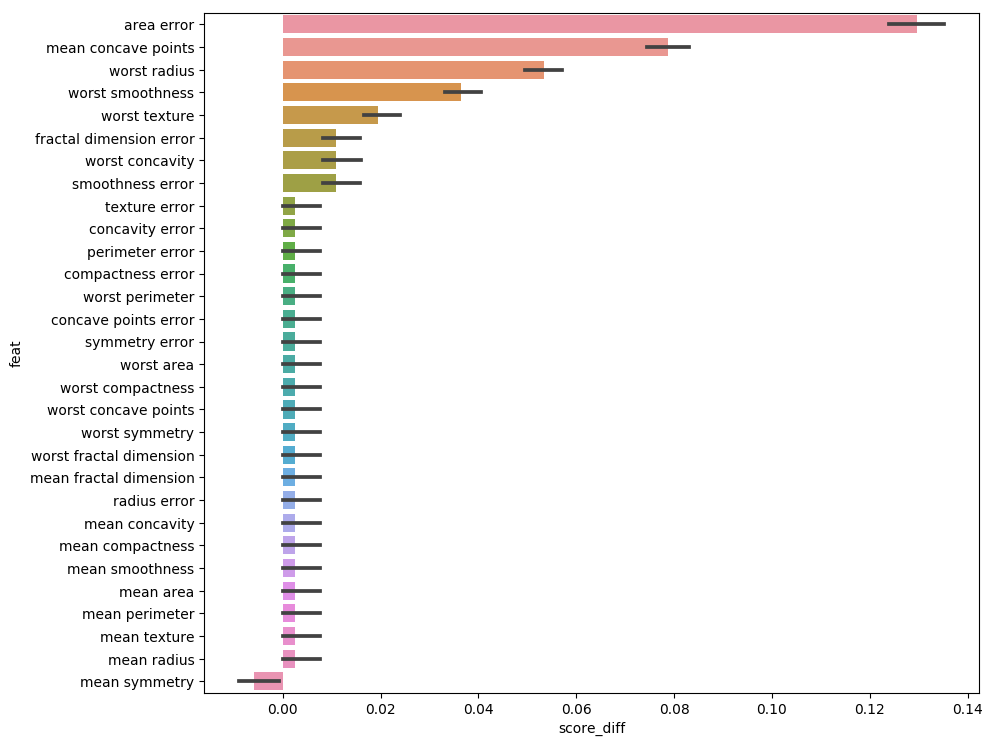

In [189]:
df_result = pi.df_result
dfa = df_result.copy()
dfb = df_result.copy()
dfb['score_diff']= dfb['score_diff'].values + 0.01
dfc = df_result.copy()
dfc['score_diff']= dfc['score_diff'].values * 1.1
dfd = df_result.copy()
dfe = df_result.copy()

dfs = [dfa, dfb, dfc, dfd] 
df_concat = pd.concat(dfs)

plt.figure(figsize=(10, int(0.3*len(df_result))), dpi=100)
sns.barplot(x="score_diff", y='feat', data=df_concat.sort_values(by='score_diff', ascending=False))
plt.savefig('permutation_importance.png')